# RBC

Solve the **RBC model** to compare with **Aiyagari + aggregate uncertainty**.

In [1]:
using Distributions
using Plots
using DataFrames
using Random
using ForwardDiff
using LinearAlgebra
#pgfplotsx()
Random.seed!(1234);

In [2]:
struct RBCParams
    """
    immutable struct that contains parameters of the model
    """
    #Economic Parameters
    alpha::Float64
    beta::Float64
    gamma::Float64
    delta::Float64
    rho::Float64
    #Other parameters
    nX::Int64 #number of aggregate variables
    nEps::Int64 #dimension of shock
    iZ::Int64 #index for the value of Z (aggregate productivity)
    iR::Int64 #index for the value of R (interest rate)
    iK::Int64 #index for the value of K (capital)
    iY::Int64 #index for the value of Y (output)
    iC::Int64 #index for the value of C (consumption)
end

# Constructor for type Params
# Values taken from here: https://alisdairmckay.com/Notes/HetAgents/index.html
function RBCParams( ; alpha::Float64 = 0.4, beta::Float64 = 0.98, gamma::Float64 = 2.0, 
                    delta::Float64 = 0.02, rho::Float64 = 0.95,
                    nX::Int64 = 5, nEps::Int64 = 1)
    # Indices
    iZ, iR, iK, iY, iC = collect(1:1:nX)
    
    RBCParams(alpha,
            beta,
            gamma,
            delta,
            rho,
            nX, 
            nEps,
            iZ,
            iR,
            iK,
            iY,
            iC)
end

RBCParams

In [3]:
function SteadyState(p::RBCParams)
    """
    Function that returns the non-stochastic steady-state of the model
    """
    X = zeros(p.nX) #initialization
    Z = 1.0 
    R = 1.0/p.beta
    K = ((R - 1.0 + p.delta)/p.alpha)^(1.0/(p.alpha - 1.0))
    Y = K^p.alpha
    C = Y - p.delta*K
    
    X[p.iZ] = Z
    X[p.iR] = R
    X[p.iK] = K
    X[p.iY] = Y
    X[p.iC] = C
    
    return X
end

SteadyState (generic function with 1 method)

In [4]:
function Fsys!(result::AbstractArray, X_Lag::AbstractArray, X::AbstractArray, X_Prime::AbstractArray, epsilon::AbstractArray, p::RBCParams)
    """
    Function that defines the economic model.
    Function that mutates the vector result
    """
    result[1] = p.beta * X_Prime[p.iR] * X_Prime[p.iC]^(- p.gamma) * (X[p.iC]^p.gamma) - 1.0 # Euler equation
    result[2] = p.alpha * X[p.iZ] * X_Lag[p.iK]^(p.alpha - 1.0) + 1.0 - p.delta - X[p.iR] # MPK
    result[3] = (1.0 - p.delta) * X_Lag[p.iK] + X[p.iY] - X[p.iC] - X[p.iK]# Aggregate resource constraint
    result[4] = X[p.iZ] * X_Lag[p.iK]^p.alpha - X[p.iY] # Production function
    result[5] = p.rho * log(X_Lag[p.iZ]) + epsilon[1] - log(X[p.iZ]) # TFP evolution
    
end

Fsys! (generic function with 1 method)

In [5]:
function Fsys_to_diff(x, index::Int64, x_ss::Vector, e_ss::Vector, p::RBCParams)
    """
    Function that wraps Fsys! to make it amenable to ForwardDiff
    """
    results = zeros(eltype(x), p.nX) #results should be of the right type for ForwardDiff to work
    if index == 1
        Fsys!(results, x, x_ss, x_ss, e_ss, p)
    elseif index == 2
       Fsys!(results, x_ss, x, x_ss, e_ss, p)
    elseif index == 3
        Fsys!(results, x_ss, x_ss, x, e_ss, p)
    elseif index == 4
        Fsys!(results, x_ss, x_ss, x_ss, x, p)
    else
        error("Index out of bound. index = $(index).")
    end
    return results
end

Fsys_to_diff (generic function with 1 method)

In [6]:
RBCp = RBCParams()
x_ss = SteadyState(RBCp)
epsilon_ss = [0.0] #shock at the non-stochastic steady-state is 0
print("Steady state: $(x_ss)")
print("Epsilon state: $(epsilon_ss)")

Steady state: [1.0, 1.0204081632653061, 45.63711005516377, 4.610279485164506, 3.697537284061231]Epsilon state: [0.0]

In [7]:
# By linearization, we obtain a system of the form:
# Ax_{t-1} + Bx_{t} + Cx_{t+1} + u_t = 0
A = ForwardDiff.jacobian(x -> Fsys_to_diff(x, 1, x_ss, epsilon_ss, RBCp), x_ss)
B = ForwardDiff.jacobian(x -> Fsys_to_diff(x, 2, x_ss, epsilon_ss, RBCp), x_ss)
C = ForwardDiff.jacobian(x -> Fsys_to_diff(x, 3, x_ss, epsilon_ss, RBCp), x_ss);

### Solve linear rational expectation model

In [8]:
function t_iteration(A::Array{Float64,2},
                    B::Array{Float64,2},
                    C::Array{Float64,2},
                    mu::Float64;
                    tol::Float64=1e-12,
                    max_iter::Int64 = 1000,
                    F0::Array{Float64,2} = Array{Float64}(undef, 0, 0),
                    S0::Array{Float64,2} = Array{Float64}(undef, 0, 0),
                    verbose::Bool=false)
    
    """
    Function to solve linear rational expectation models using the linear time iteration
    algorithm of Pontus Rendhal (2017)
    See: https://sites.google.com/site/pontusrendahl/Research
    and https://julienpascal.github.io/post/lineartimeiteration2/
    """

    # success flag:
    flag = 0

    # Initialization
    dim = size(A,2)
    if isempty(F0) == true
        F = zeros(dim,dim)
    else
        F = F0
    end
    if isempty(S0) == true
        S = zeros(dim,dim)
    else
        S = S0
    end

    eye = zeros(dim,dim)
    for i = 1:dim
        eye[i,i] = 1.0
    end

    I = eye*mu
    Ch = C
    Bh = (B+C*2*I)
    Ah = (C*I^2+B*I+A)

    #Check the reciprocal condition number
    if 1/cond(Ah,1) < 1e-16
        error("Matrix Ah is singular")
    end

    metric = 1;
    nb_iter = 0

    while metric>tol
        nb_iter+=1
        #\(x, y)
        #Left division operator:
        #multiplication of y by the inverse of x on the left.
        F = -(Bh+Ch*F)\Ah
        S = -(Bh+Ah*S)\Ch;

        metric1 = maximum(abs.(Ah+Bh*F+Ch*F*F))
        metric2 = maximum(abs.(Ah*S*S+Bh*S+Ch))
        metric = max(metric1, metric2)

        if nb_iter == max_iter
            if verbose == true
                print("Maximum number of iterations reached. Convergence not reached.")
                print("metric = $metric")
            end
            break
        end
    end


    eig_F = maximum(abs.(eigvals(F)));
    eig_S = maximum(abs.(eigvals(S)));

    if eig_F>1 || eig_S>1 || mu>1-eig_S
        if verbose == true
            println("Conditions of Proposition 3 violated")
        end
    else
        flag = 1
    end

    F = F+I;
    Q = -inv(B+C*F);

    return F, Q, flag

end

t_iteration (generic function with 1 method)

In [9]:
# Convert to log-linear system:
# M = ones(RBCp.nX,1)*transpose(x_ss)
# A = A.*M; B = B.*M; C = C.*M;

F, Q, flag = t_iteration(A, B, C, 1e-7);
print("Convergence flag = $(flag)")

Convergence flag = 1

### IRF

In [10]:
nb_periods = 200
xx = zeros(RBCp.nX, nb_periods)
uu = zeros(RBCp.nX, nb_periods)
# shock
uu[:,1] = [0.0 0.0 0.0 0.0 1.0]

for t=2:nb_periods
    # Law of motion
    xx[:,t] = F * xx[:,t-1] + Q * uu[:,t-1]
end

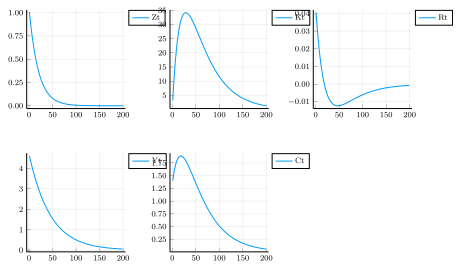

In [11]:
p1 = plot(xx[RBCp.iZ,2:end], label = "Zt")
p2 = plot(xx[RBCp.iK,2:end], label = "Kt")
p3 = plot(xx[RBCp.iR,2:end], label = "Rt")
p4 = plot(xx[RBCp.iY,2:end], label = "Yt")
p5 = plot(xx[RBCp.iC,2:end], label = "Ct")
p0 = plot(p1,p2,p3,p4,p5)

### Stochastic simulations

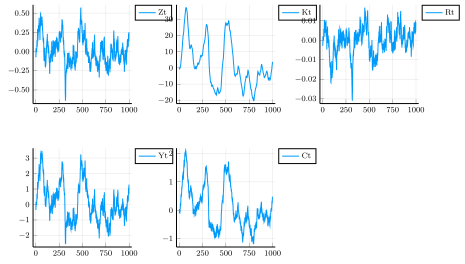

In [15]:
stoch_simul = false
if stoch_simul == true
    using Distributions
    d = Normal(0,0.05)

    nb_periods = 1000
    xx = zeros(RBCp.nX, nb_periods)
    uu = zeros(RBCp.nX, nb_periods)
    #initialization
    uu[5,:] = rand(d, nb_periods) #series of shocks

    for t=2:nb_periods
        # Law of motion
        xx[:,t] = F * xx[:,t-1] + Q * uu[:,t-1]
    end

    p1 = plot(xx[RBCp.iZ,2:end], label = "Zt")
    p2 = plot(xx[RBCp.iK,2:end], label = "Kt")
    p3 = plot(xx[RBCp.iR,2:end], label = "Rt")
    p4 = plot(xx[RBCp.iY,2:end], label = "Yt")
    p5 = plot(xx[RBCp.iC,2:end], label = "Ct")
    p0 = plot(p1,p2,p3,p4,p5)
    p0
end